In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy

from phase_vocoder import PhaseVocoder

import IPython.display as ipd
from IPython.display import display

%matplotlib inline

### Алгоритм

Задача состоит в том, чтобы изменить длительность аудиосинала, не изменяя частоту основного тона сигнала (`pitch`). 

В дальнейшем, это можно использовать в задаче `pitch shift`, позволяя создавать вокальные эффекты путем изменения высоты звка: для этого достаточно, например, растянуть сигнал в 2 раза, и потом проиграть его в 2 раза быстрее. Тогда, частоты будут удвоены, и pitch будет смещен.  

<img src="resource\fig_3_1.png"  width="50%" height="50%">

Фазовый вокодер используется в этом случае для растяжения сигнала по времени без изменения высоты тона и устранения эффектов, появляющихся после применения оконного преобразования Фурье (настройка когерентности фаз). Алгоритм фазового вокодера состоит из нескольких этапов (см. картинку ниже). Также, хорошее описание можно найти по [ссылке](https://www.ee.columbia.edu/~dpwe/e6820/papers/FlanG66.pdf).

<img src="resource\fig_3_5.png"  width="50%" height="50%">

Теперь, если вопроизвести результат с исходной частотой дискретизации, то получается растянутый/сжатый относительно времени сигнал. Поэтому, например, для задачи `pitch shift`, необходимо пересчитать частоту дискретизации выходного сигнала.

<img src="resource\Sampling_Process_ru.gif"  width="50%" height="50%">

### Визуализация работы

In [5]:
n_fft=2048
hop_length=256

In [16]:
path = 'test_mono.wav'

audio, sr = librosa.load(path)

vocoder = PhaseVocoder(n_fft, hop_length, 1 / 2)
vocoder.load_wav(path)
audio_2 = vocoder.synthesis()

vocoder = PhaseVocoder(n_fft, hop_length, 1 / 0.5)
vocoder.load_wav(path)
audio_05 = vocoder.synthesis()

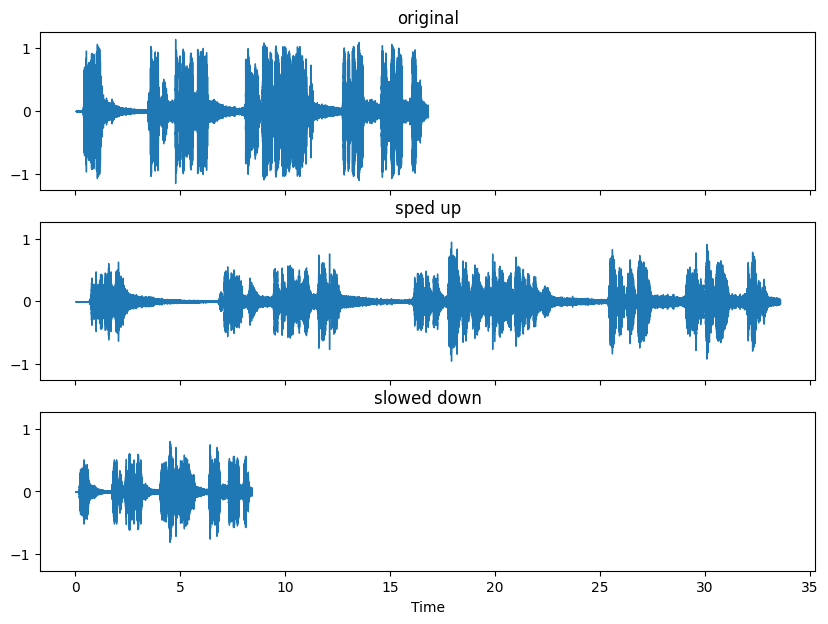

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)

ax = axs[0]
librosa.display.waveshow(audio, ax=ax, x_axis=None)
ax.set_title('original')

ax = axs[1]
librosa.display.waveshow(audio_2, ax=ax, x_axis=None)
ax.set_title('sped up')

ax = axs[2]
librosa.display.waveshow(audio_05, ax=ax, x_axis='time')
ax.set_title('slowed down');

**Можно визуализировать распределение частот после применения фазового вокодера для тестового сигнала.**

In [62]:
def draw_sig(frames, name=None, figsize=(14, 3)):
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    return


def draw_spec(spec, name=None, draw_A=True, draw_p=False, figsize=(14, 3), title=''):
    if len(spec)<100:
        draw_func = plt.stem
    else:
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title(f"Amplitude spectrum {title}")
        spec, freq = scipy.fft.fft(spec), scipy.fft.fftfreq(len(spec), 1/sr)
        spec_A = get_amplitude_from_spec(spec)
        draw_func(freq, spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 


def get_amplitude_from_spec(spec):
    return np.abs(spec)


def get_phi_from_spec(spec):
    return np.angle(spec)

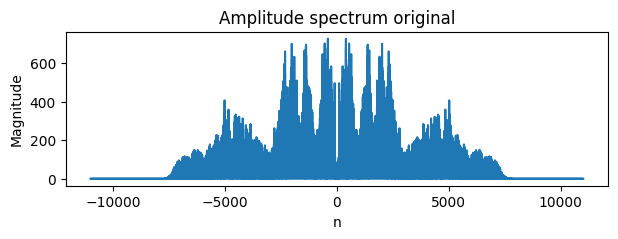

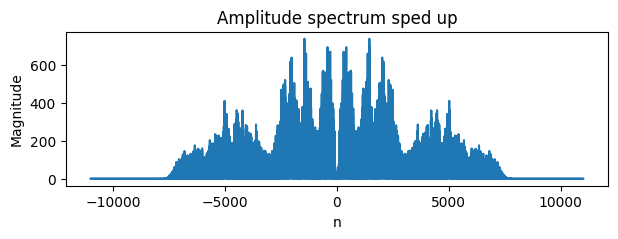

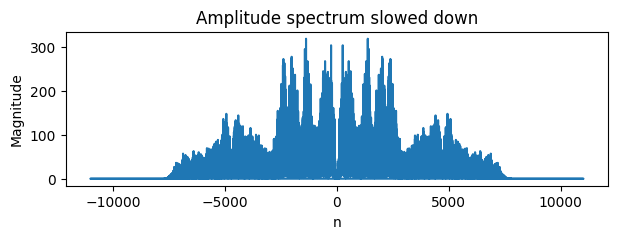

In [61]:
draw_spec(audio, title='original', figsize=(7, 2))
draw_spec(audio_2, title='sped up', figsize=(7, 2))
draw_spec(audio_05, title='slowed down', figsize=(7, 2))

**Также, можно посмотреть распределение частот для более простого примера**

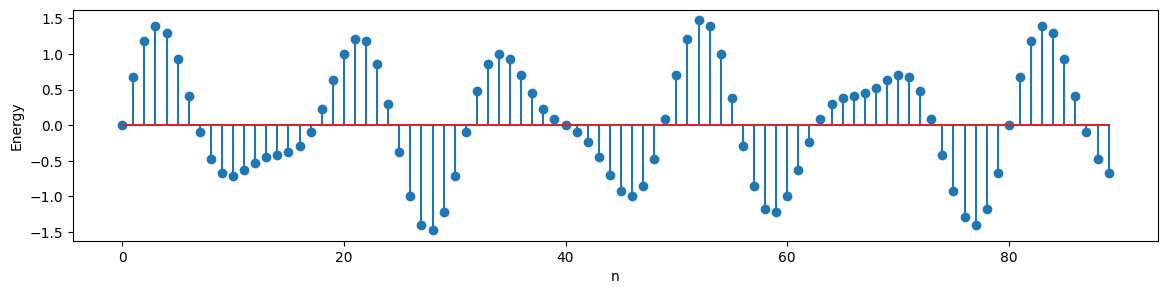

In [67]:
N = 90
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
draw_sig(y)

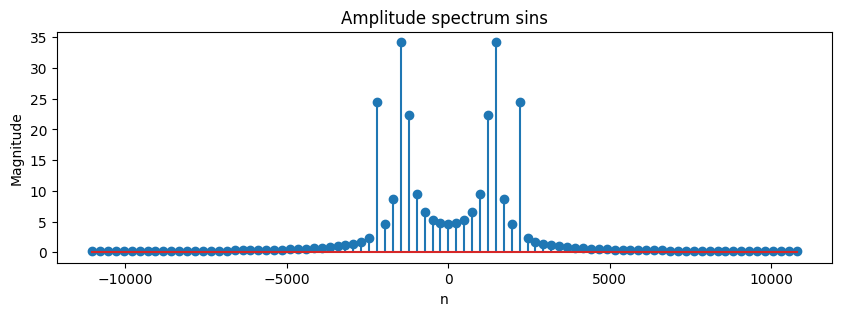

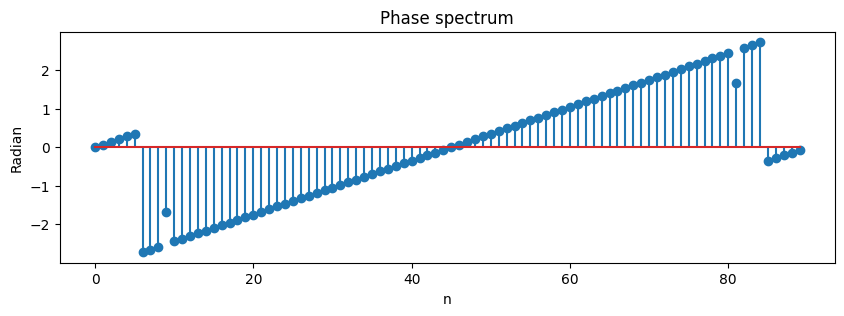

In [70]:
draw_spec(y, title='y', figsize=(10, 3), draw_p=True)

In [77]:
sin_ = PhaseVocoder(4, 1, 1/0.98)
sin_.wav = y
y_sped = sin_.synthesis()

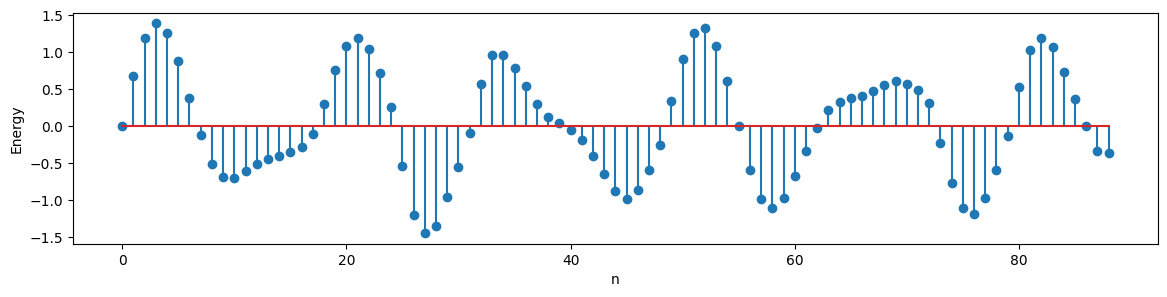

In [78]:
draw_sig(y_sped)

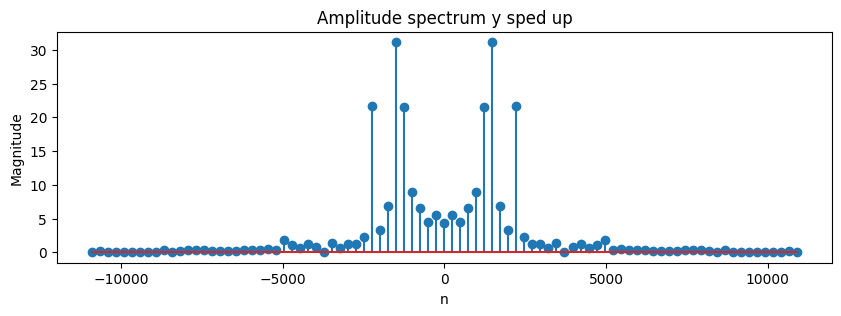

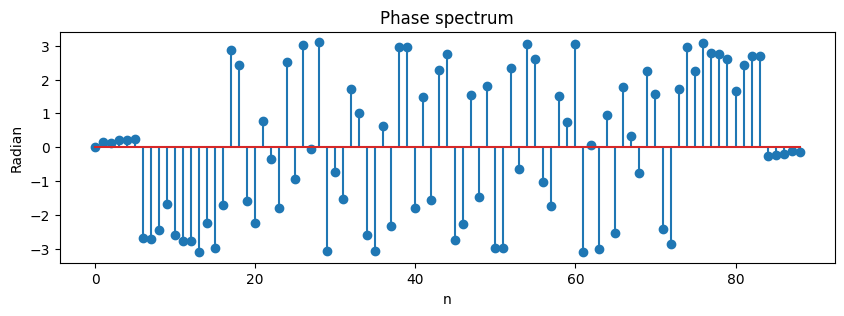

In [79]:
draw_spec(y_sped, title='y sped up', figsize=(10, 3), draw_p=True)